# Técnicas Fundamentales de Machine Learning

## Introducción

En este notebook se muestra una recopilación de conceptos cruciales para construir modelos de Machine Learning robustos y eficientes. Entender cómo evaluar, mejorar y regularizar nuestros modelos es fundamental para evitar errores comunes y obtener resultados fiables en aplicaciones reales de IA y Big Data.    

A lo largo de este cuaderno, se abordan técnicas como la gestión del overfitting y underfitting, la validación cruzada, la codificación de variables categóricas, la reducción de dimensionalidad, la regularización y la optimización de hiperparámetros.

## 1. Overfitting, Underfitting y Generalización

**Generalización:** El objetivo principal de un modelo de Machine Learning no es solo aprender de los datos de entrenamiento, sino **generalizar** bien a datos nuevos y nunca antes vistos. Un modelo que generaliza bien captura los patrones subyacentes en los datos, en lugar de memorizar el ruido o detalles específicos del conjunto de entrenamiento.

**Underfitting (Subajuste):**
* **Descripción:** Ocurre cuando el modelo es **demasiado simple** para capturar la complejidad de los datos. No aprende bien ni siquiera los datos de entrenamiento.
* **Síntomas:** Error alto tanto en el conjunto de entrenamiento como en el de validación/test.
* **Causas Comunes:** Usar un modelo lineal para datos no lineales, pocas características, regularización excesiva.
* **Soluciones:** Usar modelos más complejos (e.g., polinomios de mayor grado, redes neuronales más profundas), ingeniería de características (añadir más features), reducir la regularización.

**Overfitting (Sobreajuste):**
* **Descripción:** Ocurre cuando el modelo es **demasiado complejo** y aprende no solo los patrones subyacentes, sino también el ruido y las fluctuaciones aleatorias específicas del conjunto de entrenamiento.
* **Síntomas:** Error muy bajo en el conjunto de entrenamiento, pero error significativamente más alto en el conjunto de validación/test. El modelo no generaliza bien.
* **Causas Comunes:** Modelos muy complejos (muchos parámetros), datos insuficientes, entrenamiento excesivo.
* **Soluciones:** Conseguir más datos, reducir la complejidad del modelo, técnicas de regularización (L1, L2, Dropout), Early Stopping, Cross-Validation.

**Equilibrio (Bias-Variance Tradeoff):**   
El underfitting está relacionado con un alto **sesgo (bias)** - el modelo hace suposiciones incorrectas sobre los datos. El overfitting está relacionado con una alta **varianza** - el modelo es muy sensible a pequeñas fluctuaciones en los datos de entrenamiento. El objetivo es encontrar un punto óptimo que minimice ambos.

Características usadas: ['sepal length (cm)', 'sepal width (cm)']
Clases: ['setosa' 'versicolor' 'virginica']


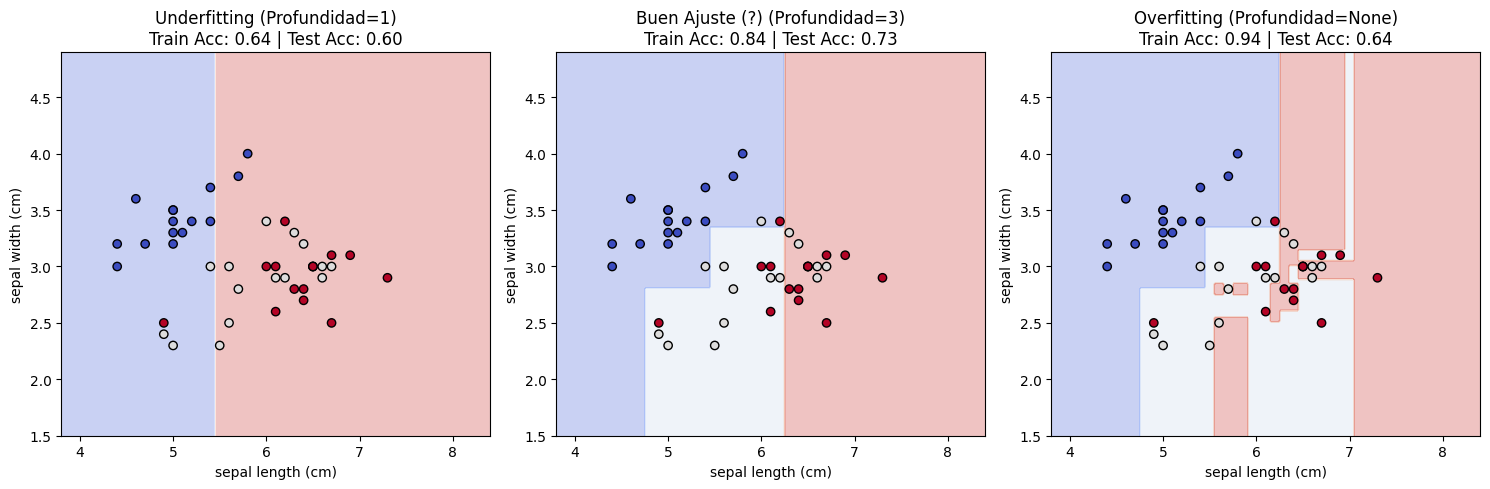

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree # Importamos plot_tree también
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- 1. Cargar Datos Iris (solo 2 características) ---
iris = load_iris()
# Usamos solo las dos primeras características: longitud y anchura del sépalo
X = iris.data[:, :2]
y = iris.target
feature_names = iris.feature_names[:2]
class_names = iris.target_names

print(f"Características usadas: {feature_names}")
print(f"Clases: {class_names}")

# --- 2. Dividir Datos ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# stratify=y asegura que la proporción de clases sea similar en train y test

# --- 3. Función para Graficar Regiones de Decisión ---
# (Esta función auxiliar nos ayuda a visualizar)
def plot_decision_boundary(clf, X, y, ax, title):
    h = .02  # Tamaño del paso en la malla
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predecir para cada punto de la malla
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Dibujar las regiones de decisión
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)

    # Dibujar los puntos de datos (test set en este caso)
    scatter = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm, edgecolor='k')
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(title)
    # Crear leyenda a partir de los puntos scatter
    # legend1 = ax.legend(*scatter.legend_elements(), title="Clases")
    # ax.add_artist(legend1)


# --- 4. Entrenar y Visualizar Modelos ---
depths = [1, 3, None] # None significa sin límite de profundidad
titles = ['Underfitting (Profundidad=1)',
          'Buen Ajuste (?) (Profundidad=3)',
          'Overfitting (Profundidad=None)']

plt.figure(figsize=(15, 5)) # Figura más ancha para 3 subplots

for i, depth in enumerate(depths):
    # Crear y entrenar el árbol
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Evaluar precisión (accuracy)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    # Graficar regiones de decisión en un subplot
    ax = plt.subplot(1, len(depths), i + 1)
    plot_title = f"{titles[i]}\nTrain Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f}"
    plot_decision_boundary(clf, X, y, ax, plot_title)

plt.tight_layout()
plt.show()

# --- (Opcional) Visualizar uno de los árboles ---
# plt.figure(figsize=(12,8))
# tree_to_plot = DecisionTreeClassifier(max_depth=3, random_state=42).fit(X_train, y_train)
# plot_tree(tree_to_plot, filled=True, feature_names=feature_names, class_names=class_names, rounded=True)
# plt.title("Árbol de Decisión (Profundidad=3)")
# plt.show()

## 2. Cross Validation (Validación Cruzada)

**¿Por qué es necesaria?**
Cuando dividimos los datos en un único conjunto de entrenamiento y uno de test (hold-out), la evaluación del modelo puede depender mucho de *cómo* se hizo esa división específica. Podríamos tener suerte (o mala suerte) con la división.

**Validación Cruzada K-Fold:**
Es una técnica más robusta para evaluar la capacidad de generalización de un modelo. El procedimiento es:
1.  Dividir aleatoriamente el conjunto de datos original en *K* subconjuntos (o "folds") de tamaño aproximadamente igual.
2.  Realizar *K* iteraciones:
    * En cada iteración *i*, usar el fold *i* como conjunto de validación y los *K-1* folds restantes como conjunto de entrenamiento.
    * Entrenar el modelo con los datos de entrenamiento y evaluarlo con los datos de validación.
3.  Calcular la métrica de evaluación deseada (e.g., accuracy, MSE) para cada una de las *K* iteraciones.
4.  El rendimiento final del modelo se estima como la media (y a menudo también la desviación estándar) de las *K* métricas obtenidas.

**Ventajas:**
* Proporciona una estimación más fiable del rendimiento del modelo en datos no vistos.
* Reduce la dependencia de una única división train/test.
* Utiliza todos los datos tanto para entrenamiento como para validación a lo largo de las K iteraciones.

**Variantes Comunes:**
* **Stratified K-Fold:** Mantiene la proporción de las clases en cada fold (importante para clasificación desbalanceada).
* **Leave-One-Out (LOO):** Es un caso extremo de K-Fold donde K es igual al número de muestras. Cada muestra se usa una vez como conjunto de validación. Muy costoso computacionalmente.

In [2]:
# Ejemplo: Cross Validation K-Fold con Scikit-learn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

# Cargar datos de ejemplo
iris = load_iris()
X, y = iris.data, iris.target

# Crear el modelo
model = LogisticRegression(max_iter=200) # Aumentar max_iter para convergencia

# Definir la estrategia de Cross Validation (K=5 folds)
# shuffle=True asegura que los datos se mezclan antes de dividir
# random_state asegura reproducibilidad
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Realizar la validación cruzada
# 'scoring' puede ser 'accuracy', 'neg_mean_squared_error', etc.
scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print(f"Scores de Accuracy para cada Fold: {scores}")
print(f"Accuracy Media (CV): {scores.mean():.4f}")
print(f"Desviación Estándar del Accuracy (CV): {scores.std():.4f}")

# Nota: Para clasificación, a menudo es mejor usar StratifiedKFold
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stratified_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
print(f"\nScores usando Stratified K-Fold: {stratified_scores}")
print(f"Accuracy Media (Stratified CV): {stratified_scores.mean():.4f}")

Scores de Accuracy para cada Fold: [1.         1.         0.93333333 0.96666667 0.96666667]
Accuracy Media (CV): 0.9733
Desviación Estándar del Accuracy (CV): 0.0249

Scores usando Stratified K-Fold: [1.         0.96666667 0.93333333 1.         0.93333333]
Accuracy Media (Stratified CV): 0.9667


## 3. One Hot Encoding

**¿Qué es?**
Muchos algoritmos de Machine Learning requieren que las variables de entrada sean numéricas. One Hot Encoding (OHE) es una técnica común para convertir **variables categóricas nominales** (aquellas donde las categorías no tienen un orden inherente, como "Color": Rojo, Azul, Verde) en un formato numérico que los algoritmos puedan entender.

**¿Cómo funciona?**
1.  Identifica todas las categorías únicas en la columna categórica.
2.  Crea una nueva columna binaria (0 o 1) para cada categoría única.
3.  Para cada fila (observación):
    * Asigna un '1' en la columna correspondiente a la categoría de esa fila.
    * Asigna '0' en todas las demás columnas nuevas creadas para esa característica original.

**Ejemplo:**
Si tenemos una columna "Ciudad" con categorías ["Madrid", "León", "Valladolid"]:
* Se crearían 3 nuevas columnas: "Ciudad_Madrid", "Ciudad_León", "Ciudad_Valladolid".
* Una fila con Ciudad="León" se transformaría en [0, 1, 0].
* Una fila con Ciudad="Valladolid" se transformaría en [0, 0, 1].

**Consideraciones:**
* **Dummy Variable Trap:** Si incluimos una columna binaria para *cada* categoría, las columnas resultantes son perfectamente multicolineales (una se puede predecir a partir de las otras). Esto puede causar problemas en algunos modelos (como regresión lineal). Solución: eliminar una de las columnas OHE (la información no se pierde, ya que la categoría eliminada se representa con ceros en las demás). Muchas librerías lo hacen automáticamente o tienen una opción (`drop='first'`).
* **Alta Dimensionalidad:** Si una variable categórica tiene muchas categorías, OHE puede crear una gran cantidad de nuevas características, aumentando la dimensionalidad y potencialmente llevando a la "maldición de la dimensionalidad" o overfitting. En estos casos, se pueden considerar otras técnicas (como Target Encoding, Hashing, o agrupar categorías raras).

In [3]:
# Ejemplo: One Hot Encoding con Pandas y Scikit-learn

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Datos de ejemplo
data = {'Ciudad': ['Madrid', 'León', 'Valladolid', 'León', 'Madrid'],
        'Temperatura': [25, 18, 22, 19, 26]}
df = pd.DataFrame(data)

print("DataFrame Original:")
print(df)

# --- Opción 1: Usando Pandas get_dummies ---
# Simple y directo para DataFrames
# drop_first=True evita la Dummy Variable Trap
df_ohe_pandas = pd.get_dummies(df, columns=['Ciudad'], drop_first=True, prefix='Ciudad')

print("\nDataFrame con OHE (Pandas get_dummies):")
print(df_ohe_pandas)

# --- Opción 2: Usando Scikit-learn OneHotEncoder ---
# Más flexible, se integra mejor en pipelines de Scikit-learn
# Necesita que la entrada sea numérica o usar handle_unknown='ignore'
# Por defecto crea una matriz dispersa (sparse matrix) para eficiencia

# Crear el encoder
# drop='first' para evitar multicolinealidad
# sparse_output=False para obtener un array numpy denso (más fácil de ver)
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Ajustar y transformar la columna 'Ciudad'
# reshape(-1, 1) es necesario porque espera una entrada 2D
ciudad_encoded = encoder.fit_transform(df[['Ciudad']])

# Crear un DataFrame con las nuevas columnas
# get_feature_names_out da los nombres de las columnas creadas
df_ohe_sklearn = pd.DataFrame(ciudad_encoded, columns=encoder.get_feature_names_out(['Ciudad']))

# Combinar con las columnas no codificadas
df_final_sklearn = pd.concat([df.drop('Ciudad', axis=1), df_ohe_sklearn], axis=1)

print("\nDataFrame con OHE (Scikit-learn OneHotEncoder):")
print(df_final_sklearn)

DataFrame Original:
       Ciudad  Temperatura
0      Madrid           25
1        León           18
2  Valladolid           22
3        León           19
4      Madrid           26

DataFrame con OHE (Pandas get_dummies):
   Temperatura  Ciudad_Madrid  Ciudad_Valladolid
0           25           True              False
1           18          False              False
2           22          False               True
3           19          False              False
4           26           True              False

DataFrame con OHE (Scikit-learn OneHotEncoder):
   Temperatura  Ciudad_Madrid  Ciudad_Valladolid
0           25            1.0                0.0
1           18            0.0                0.0
2           22            0.0                1.0
3           19            0.0                0.0
4           26            1.0                0.0


## 4. PCA (Principal Component Analysis)

**¿Qué es?**
PCA es una técnica de **reducción de dimensionalidad no supervisada**. Su objetivo es transformar un conjunto de datos con muchas variables (posiblemente correlacionadas) en un nuevo conjunto de variables (menos dimensiones) llamadas **Componentes Principales (CPs)**, manteniendo la mayor cantidad posible de la varianza (información) original.

**Idea Intuitiva:**
Imagina una nube de puntos en 3D. PCA busca la dirección (eje) en la que los puntos se extienden más (la dirección de máxima varianza). Ese es el primer Componente Principal (CP1). Luego, busca la siguiente dirección, perpendicular a la primera, que capture la mayor varianza restante (CP2), y así sucesivamente.

**¿Cómo funciona (a grandes rasgos)?**
1.  **Estandarizar los datos:** Es crucial escalar las características para que tengan media 0 y desviación estándar 1, ya que PCA es sensible a la escala.
2.  **Calcular la matriz de covarianza:** Mide cómo las variables varían conjuntamente.
3.  **Calcular los autovectores y autovalores** de la matriz de covarianza:
    * **Autovectores:** Representan las direcciones de los Componentes Principales.
    * **Autovalores:** Indican la cantidad de varianza explicada por cada Componente Principal.
4.  **Ordenar los Componentes Principales:** Se ordenan los autovectores según sus autovalores correspondientes, de mayor a menor.
5.  **Seleccionar el número de componentes:** Se elige un número *k* de componentes principales (los de mayor autovalor) que capturen un porcentaje deseado de la varianza total (e.g., 95%).
6.  **Proyectar los datos:** Se transforma el conjunto de datos original al nuevo subespacio de *k* dimensiones definido por los componentes principales seleccionados.

**Usos:**
* **Reducción de dimensionalidad:** Para acelerar algoritmos, reducir ruido, combatir la maldición de la dimensionalidad.
* **Visualización:** Reducir datos a 2 o 3 dimensiones para poder graficarlos.
* **Compresión de datos.**
* **Ingeniería de características.**

**Limitaciones:**
* Asume relaciones lineales.
* Los componentes principales no siempre son fácilmente interpretables.
* Sensible a la escala de los datos.
* No utiliza información de la variable objetivo (es no supervisado).

Dimensiones originales: 4
Dimensiones reducidas: 2
Varianza explicada por componente: [0.72962445 0.22850762]
Varianza total explicada (2 componentes): 0.9581


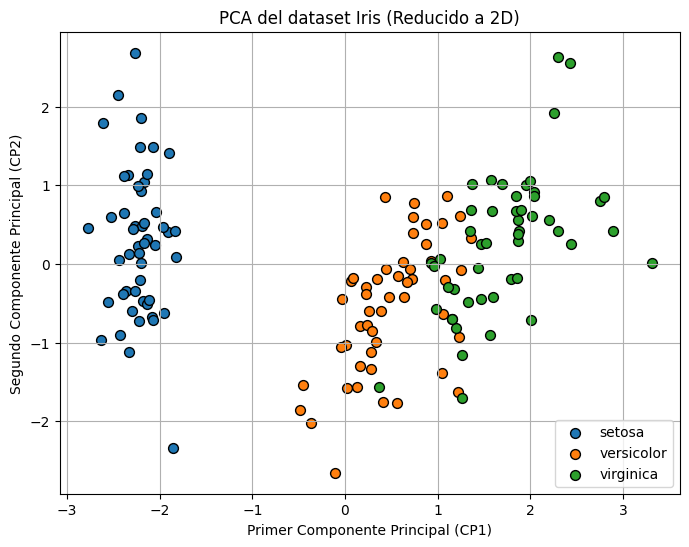


Componentes Principales (Autovectores):
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
CP1           0.521066         -0.269347           0.580413          0.564857
CP2           0.377418          0.923296           0.024492          0.066942


In [ ]:
# Ejemplo: PCA con Scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

# Cargar datos (usaremos Iris de nuevo, tiene 4 características)
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

# 1. Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Aplicar PCA
# n_components puede ser un número entero (k) o un float (0 < n < 1)
# Si es float, selecciona componentes hasta explicar esa proporción de varianza
# pca = PCA(n_components=0.95) # Explicar el 95% de la varianza
pca = PCA(n_components=2)   # Reducir a 2 dimensiones para visualizar

X_pca = pca.fit_transform(X_scaled) 

# 3. Analizar resultados
print(f"Dimensiones originales: {X_scaled.shape[1]}")
print(f"Dimensiones reducidas: {X_pca.shape[1]}")

# Varianza explicada por cada componente
print(f"Varianza explicada por componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada (2 componentes): {pca.explained_variance_ratio_.sum():.4f}")

# 4. Visualizar los datos transformados 
plt.figure(figsize=(8, 6))

# Iterar sobre cada clase (0, 1, 2) y su nombre correspondiente
for i, target_name in enumerate(iris.target_names):
    # Seleccionar los puntos que pertenecen a la clase actual (y == i)
    # Graficar solo esos puntos, asignando la etiqueta correcta
    plt.scatter(X_pca[y == i, 0], # Coordenada X (CP1) de los puntos de la clase i
                X_pca[y == i, 1], # Coordenada Y (CP2) de los puntos de la clase i
                edgecolor='k',
                s=50,
                label=target_name) # Asignar el nombre de la clase como etiqueta

plt.xlabel('Primer Componente Principal (CP1)')
plt.ylabel('Segundo Componente Principal (CP2)')
plt.title('PCA del dataset Iris (Reducido a 2D)')
plt.legend() # Matplotlib ahora usa las etiquetas de los scatter plots
plt.grid(True)
plt.show()

# Componentes (combinaciones lineales de las características originales)
print("\nComponentes Principales (Autovectores):")
print(pd.DataFrame(pca.components_, columns=feature_names, index=['CP1', 'CP2']))

## 5. Regularización (L1 y L2)

**¿Qué es?**
La regularización es un conjunto de técnicas utilizadas para **prevenir el overfitting** en modelos de Machine Learning, especialmente en regresiones y redes neuronales. Lo hace añadiendo un **término de penalización** a la función de coste (loss function) del modelo. Esta penalización desalienta al modelo a asignar pesos (coeficientes) demasiado grandes a las características.

**Idea Clave:** Un modelo con coeficientes muy grandes es a menudo un signo de overfitting, ya que está dando demasiada importancia a ciertas características presentes en el ruido del conjunto de entrenamiento. La regularización fuerza al modelo a ser "más simple" o "más suave".

**Tipos Comunes:**

1.  **Regularización L2 (Ridge Regression):**
    * **Penalización:** Añade la **suma de los cuadrados** de los coeficientes, multiplicada por un hiperparámetro lambda (λ) o alpha (α).
    * **Función de Coste (Regresión Lineal):** `Cost = MSE + α * Σ(coeficiente_j)²`
    * **Efecto:** Tiende a **reducir** los valores de todos los coeficientes, acercándolos a cero, pero raramente los hace exactamente cero. Es buena para manejar multicolinealidad.

2.  **Regularización L1 (Lasso Regression):**
    * **Penalización:** Añade la **suma de los valores absolutos** de los coeficientes, multiplicada por un hiperparámetro alpha (α).
    * **Función de Coste (Regresión Lineal):** `Cost = MSE + α * Σ|coeficiente_j|`
    * **Efecto:** Puede forzar a que algunos coeficientes se vuelvan **exactamente cero**. Esto la hace útil para la **selección automática de características**, eliminando las menos importantes.

**Hiperparámetro de Regularización (α o λ):**
* Controla la **fuerza** de la penalización.
* **α = 0:** Sin regularización (equivale a Regresión Lineal/Logística estándar).
* **α pequeño:** Poca regularización.
* **α grande:** Mucha regularización (puede llevar a underfitting si es demasiado alto).
* El valor óptimo de α se suele encontrar mediante técnicas como Cross Validation y Grid Search.

**Elastic Net:** Es una combinación de L1 y L2, que intenta obtener lo mejor de ambos mundos.

Comparación de Coeficientes:
  Feature  True Coef  Linear Reg  Ridge (alpha=1.0)  Lasso (alpha=0.1)
0      F1        1.5        1.25               1.23               1.15
1      F2       -0.8       -0.89              -0.88              -0.78
2      F3        0.5        0.53               0.52               0.39
3      F4        1.2        1.28               1.25               1.17
4      F5        0.0       -0.07              -0.07              -0.00
5      F6        0.0        0.00               0.01               0.00
6      F7        0.0       -0.14              -0.13              -0.00
7      F8        0.0        0.05               0.04               0.00
8      F9        0.0        0.01               0.03               0.00
9     F10        0.0       -0.01              -0.00               0.00


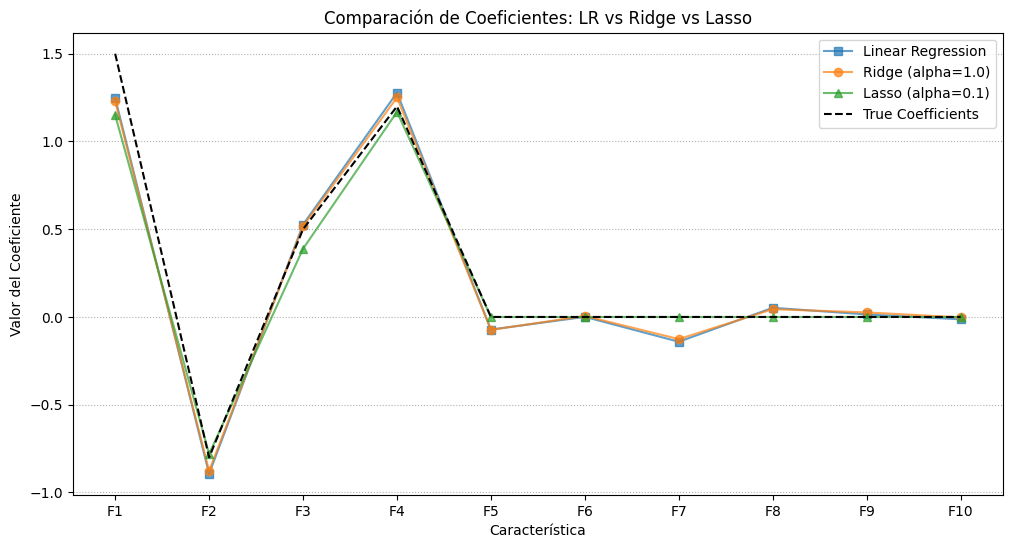


Score R^2 - Linear Regression: 0.943
Score R^2 - Ridge (alpha=1.0): 0.946
Score R^2 - Lasso (alpha=0.1): 0.949

Observa cómo Lasso pone a cero los coeficientes de las características irrelevantes (F5 a F10).


In [5]:
# Ejemplo: Regularización L1 (Lasso) y L2 (Ridge)
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt

# Generar datos sintéticos con algunas características irrelevantes
np.random.seed(42)
n_samples, n_features = 100, 10
X = np.random.randn(n_samples, n_features)
# Coeficientes reales (algunos son cero o pequeños)
true_coef = np.zeros(n_features)
true_coef[:4] = [1.5, -0.8, 0.5, 1.2] # Solo las primeras 4 features son relevantes
# Generar y (target) con ruido
y = X @ true_coef + np.random.randn(n_samples) * 0.5

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Estandarizar datos (importante para regularización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar modelos
lr = LinearRegression()
ridge = Ridge(alpha=1.0) # Alpha es el hiperparámetro de regularización L2
lasso = Lasso(alpha=0.1) # Alpha es el hiperparámetro de regularización L1

lr.fit(X_train_scaled, y_train)
ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train)

# Comparar coeficientes
coefficients = pd.DataFrame({
    'Feature': [f'F{i+1}' for i in range(n_features)],
    'True Coef': true_coef,
    'Linear Reg': lr.coef_,
    'Ridge (alpha=1.0)': ridge.coef_,
    'Lasso (alpha=0.1)': lasso.coef_
})

print("Comparación de Coeficientes:")
print(coefficients.round(2))

# Visualizar coeficientes
plt.figure(figsize=(12, 6))
plt.plot(coefficients['Linear Reg'], 's-', label='Linear Regression', alpha=0.7)
plt.plot(coefficients['Ridge (alpha=1.0)'], 'o-', label='Ridge (alpha=1.0)', alpha=0.7)
plt.plot(coefficients['Lasso (alpha=0.1)'], '^-', label='Lasso (alpha=0.1)', alpha=0.7)
plt.plot(coefficients['True Coef'], 'k--', label='True Coefficients')
plt.xticks(range(n_features), coefficients['Feature'])
plt.title('Comparación de Coeficientes: LR vs Ridge vs Lasso')
plt.xlabel('Característica')
plt.ylabel('Valor del Coeficiente')
plt.legend()
plt.grid(axis='y', linestyle=':')
plt.show()

print(f"\nScore R^2 - Linear Regression: {lr.score(X_test_scaled, y_test):.3f}")
print(f"Score R^2 - Ridge (alpha=1.0): {ridge.score(X_test_scaled, y_test):.3f}")
print(f"Score R^2 - Lasso (alpha=0.1): {lasso.score(X_test_scaled, y_test):.3f}")
print("\nObserva cómo Lasso pone a cero los coeficientes de las características irrelevantes (F5 a F10).")

## 6. GridSearchCV y RandomizedSearchCV: Optimización de Hiperparámetros

**¿Qué son los Hiperparámetros?**
Son parámetros de configuración de un algoritmo de Machine Learning que **no se aprenden** directamente de los datos durante el entrenamiento, sino que **se establecen antes** de que comience el proceso de aprendizaje. Ejemplos:
* El parámetro `alpha` en Ridge y Lasso.
* El parámetro `C` y `gamma` en Support Vector Machines (SVM).
* El número de vecinos `k` en K-Nearest Neighbors (KNN).
* El número de árboles y la profundidad máxima en un Random Forest.
* La tasa de aprendizaje (learning rate) en redes neuronales y gradient boosting.

La elección de los hiperparámetros correctos puede tener un impacto significativo en el rendimiento del modelo.

**¿Cómo encontrar los mejores Hiperparámetros?**
La búsqueda manual es tediosa e ineficiente. Se utilizan técnicas automatizadas:

1.  **GridSearchCV (Búsqueda en Rejilla):**
    * **Cómo funciona:** Define una "rejilla" de posibles valores para cada hiperparámetro que deseas ajustar. GridSearchCV prueba **todas las combinaciones posibles** de estos valores.
    * **Evaluación:** Para cada combinación, utiliza Validación Cruzada (Cross Validation) para evaluar el rendimiento del modelo.
    * **Resultado:** Devuelve la combinación de hiperparámetros que obtuvo el mejor rendimiento promedio en la validación cruzada.
    * **Pros:** Exhaustivo, garantiza encontrar la mejor combinación *dentro de la rejilla definida*.
    * **Contras:** Computacionalmente muy costoso, especialmente si hay muchos hiperparámetros o muchos valores posibles para cada uno (el número de combinaciones crece exponencialmente).

2.  **RandomizedSearchCV (Búsqueda Aleatoria):**
    * **Cómo funciona:** En lugar de probar todas las combinaciones, define un espacio de búsqueda (puede ser una lista de valores o una distribución estadística para cada hiperparámetro). RandomizedSearchCV **muestra aleatoriamente un número fijo de combinaciones** (`n_iter`) de este espacio.
    * **Evaluación:** Al igual que GridSearchCV, utiliza Validación Cruzada para evaluar cada combinación muestreada.
    * **Resultado:** Devuelve la mejor combinación encontrada entre las muestreadas.
    * **Pros:** Mucho más eficiente que GridSearchCV, especialmente con espacios de búsqueda grandes. A menudo encuentra combinaciones de hiperparámetros muy buenas (o incluso óptimas) con menos cómputo. Permite usar distribuciones para muestrear valores continuos.
    * **Contras:** No garantiza encontrar la mejor combinación absoluta (porque no prueba todas). El rendimiento depende del número de iteraciones (`n_iter`) y de la suerte en el muestreo.

**¿Cuándo usar cuál?**
* **GridSearchCV:** Cuando el espacio de búsqueda es pequeño o tienes recursos computacionales suficientes.
* **RandomizedSearchCV:** Cuando el espacio de búsqueda es grande, hay muchos hiperparámetros, o quieres explorar rangos continuos de valores. A menudo es el punto de partida preferido.

In [ ]:
# Ejemplo: GridSearchCV y RandomizedSearchCV con SVM
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint # Para distribuciones en RandomizedSearchCV

# Cargar y preparar datos
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Escalar datos (importante para SVM)
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo base
svc = SVC()

# --- GridSearchCV ---
print("--- Ejecutando GridSearchCV ---")
# Definir la rejilla de parámetros
param_grid = {
    'C': [0.1, 1, 10, 100], # Parámetro de regularización
    'gamma': [1, 0.1, 0.01, 0.001], # Coeficiente del kernel
    'kernel': ['rbf', 'linear'] # Tipos de kernel
}

# Crear el objeto GridSearchCV
# cv=5 significa 5-fold cross-validation
# n_jobs=-1 usa todos los cores disponibles
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Ajustar a los datos
grid_search.fit(X_train_scaled, y_train)

# Mostrar mejores parámetros y score
print(f"\nMejores parámetros encontrados (GridSearch): {grid_search.best_params_}")
print(f"Mejor score (Accuracy) en CV (GridSearch): {grid_search.best_score_:.4f}")
# Evaluar en el test set con el mejor modelo encontrado
best_grid_model = grid_search.best_estimator_
test_score_grid = best_grid_model.score(X_test_scaled, y_test)
print(f"Score en Test set (GridSearch): {test_score_grid:.4f}")


# --- RandomizedSearchCV ---
print("\n--- Ejecutando RandomizedSearchCV ---")
# Definir el espacio de búsqueda (puede incluir distribuciones)
param_dist = {
    'C': uniform(loc=0.1, scale=100), # Distribución uniforme entre 0.1 y 100.1
    'gamma': uniform(loc=0.001, scale=1), # Distribución uniforme entre 0.001 y 1.001
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': randint(2, 5) # Grado del polinomio (entero entre 2 y 4) - solo si kernel='poly'
}

# Crear el objeto RandomizedSearchCV
# n_iter = número de combinaciones a probar
random_search = RandomizedSearchCV(estimator=svc, param_distributions=param_dist, n_iter=50,
                                   cv=5, n_jobs=-1, verbose=1, random_state=42)

# Ajustar a los datos
random_search.fit(X_train_scaled, y_train)

# Mostrar mejores parámetros y score
print(f"\nMejores parámetros encontrados (RandomizedSearch): {random_search.best_params_}")
print(f"Mejor score (Accuracy) en CV (RandomizedSearch): {random_search.best_score_:.4f}")
# Evaluar en el test set con el mejor modelo encontrado
best_random_model = random_search.best_estimator_
test_score_random = best_random_model.score(X_test_scaled, y_test)
print(f"Score en Test set (RandomizedSearch): {test_score_random:.4f}")

--- Ejecutando GridSearchCV ---
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Mejores parámetros encontrados (GridSearch): {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Mejor score (Accuracy) en CV (GridSearch): 0.9810
Score en Test set (GridSearch): 0.9111

--- Ejecutando RandomizedSearchCV ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Mejores parámetros encontrados (RandomizedSearch): {'C': np.float64(91.0320402078782), 'degree': 3, 'gamma': np.float64(0.663522284353982), 'kernel': 'linear'}
Mejor score (Accuracy) en CV (RandomizedSearch): 0.9810
Score en Test set (RandomizedSearch): 0.9333


## 7. Batch Normalization y Weight Regularization

**Weight Regularization (Regularización de Pesos):**
* Este término es **sinónimo de la Regularización L1 y L2** que ya vimos (Sección 5).
* Se refiere específicamente a añadir una penalización basada en la magnitud de los **pesos** (o coeficientes) del modelo a la función de coste.
* El objetivo es el mismo: prevenir el overfitting restringiendo la complejidad del modelo (evitando pesos excesivamente grandes).
* Las técnicas principales son L1 (Lasso) y L2 (Ridge).

**Batch Normalization (Normalización por Lotes):**
* **Contexto Principal:** Es una técnica fundamentalmente utilizada en **Redes Neuronales Profundas (Deep Learning)**, aunque el concepto de normalización es general.
* **¿Qué hace?:** Normaliza las **activaciones** de una capa (la salida antes de la función de activación no lineal) para que tengan **media cero y desviación estándar uno**, *dentro de cada mini-lote (mini-batch)* durante el entrenamiento. Luego, aprende dos parámetros (gamma y beta) para escalar y desplazar estas activaciones normalizadas, permitiendo a la red aprender la mejor representación.
* **¿Por qué se hace? (Beneficios):**
    1.  **Combate el "Internal Covariate Shift":** El cambio en la distribución de las entradas de las capas internas durante el entrenamiento. Al estabilizar estas distribuciones, el entrenamiento se vuelve más estable y rápido.
    2.  **Permite Tasas de Aprendizaje (Learning Rates) más altas:** La normalización hace que el paisaje de la función de pérdida sea más suave, lo que permite usar tasas de aprendizaje mayores sin riesgo de divergencia, acelerando la convergencia.
    3.  **Actúa como Regularizador:** Introduce un ligero ruido debido a la estimación de la media y varianza en cada mini-lote, lo que tiene un efecto regularizador leve y puede reducir la necesidad de otras técnicas como Dropout.
    4.  **Reduce la sensibilidad a la inicialización de pesos:** El modelo es menos dependiente de una buena inicialización inicial.
* **Implementación:** Generalmente se implementa como una capa específica en frameworks de Deep Learning (como TensorFlow/Keras o PyTorch). Implementarla eficientemente desde cero sin estas librerías es complejo y menos común en la práctica fuera del contexto de redes neuronales profundas.

#### Ejemplo Práctico de Batch Normalization con TensorFlow/Keras

A continuación, construiremos dos modelos de redes neuronales simples para clasificar imágenes del dataset Fashion MNIST: uno *sin* Batch Normalization y otro *con* Batch Normalization. Compararemos sus curvas de aprendizaje (pérdida y precisión) para observar el efecto de BN.

**Dataset:** Usaremos Fashion MNIST, que consta de 60,000 imágenes de entrenamiento y 10,000 de prueba (28x28 píxeles en escala de grises), clasificadas en 10 categorías de ropa.

**Modelos:** Serán redes neuronales densas (fully connected) sencillas con la siguiente estructura:
1.  Capa Flatten (para convertir la imagen 2D en un vector 1D).
2.  Capa Densa con activación ReLU.
3.  (Opcional) Capa Batch Normalization.
4.  Capa Densa con activación ReLU.
5.  (Opcional) Capa Batch Normalization.
6.  Capa Densa de salida con activación Softmax (para clasificación multiclase).

**Observación:** La capa `BatchNormalization` se suele colocar *después* de la transformación lineal (capa Densa o Convolucional) y *antes* de la función de activación no lineal. Keras maneja automáticamente los parámetros gamma y beta, y actualiza las medias y varianzas móviles durante el entrenamiento.

Cargando y preprocesando datos Fashion MNIST...
Forma datos entrenamiento: (60000, 28, 28)
Forma etiquetas entrenamiento: (60000, 10)
Forma datos prueba: (10000, 28, 28)
Forma etiquetas prueba: (10000, 10)

Resumen Modelo SIN Batch Normalization:


Model: "Modelo_Sin_BN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


Resumen Modelo CON Batch Normalization:


Model: "Modelo_Con_BN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,154 (430.29 KB)

 Trainable params: 109,770 (428.79 KB)

 Non-trainable params: 384 (1.50 KB)


Entrenando Modelo SIN Batch Normalization...
Epoch 1/15
375/375 - 2s - 5ms/step - accuracy: 0.7954 - loss: 0.5861 - val_accuracy: 0.8440 - val_loss: 0.4391
Epoch 2/15
375/375 - 1s - 2ms/step - accuracy: 0.8559 - loss: 0.4041 - val_accuracy: 0.8626 - val_loss: 0.3836
Epoch 3/15
375/375 - 1s - 2ms/step - accuracy: 0.8695 - loss: 0.3616 - val_accuracy: 0.8701 - val_loss: 0.3652
Epoch 4/15
375/375 - 1s - 2ms/step - accuracy: 0.8770 - loss: 0.3363 - val_accuracy: 0.8728 - val_loss: 0.3514
Epoch 5/15
375/375 - 1s - 2ms/step - accuracy: 0.8857 - loss: 0.3150 - val_accuracy: 0.8778 - val_loss: 0.3398
Epoch 6/15
375/375 - 1s - 2ms/step - accuracy: 0.8899 - loss: 0.2982 - val_accuracy: 0.8798 - val_loss: 0.3326
Epoch 7/15
375/375 - 1s - 2ms/step - accuracy: 0.8924 - loss: 0.2874 - val_accuracy: 0.8812 - val_loss: 0.3366
Epoch 8/15
375/375 - 1s - 2ms/step - accuracy: 0.8990 - loss: 0.2729 - val_accuracy: 0.8777 - val_loss: 0.3350
Epoch 9/15
375/375 - 1s - 2ms/step - accuracy: 0.9018 - loss: 0.26

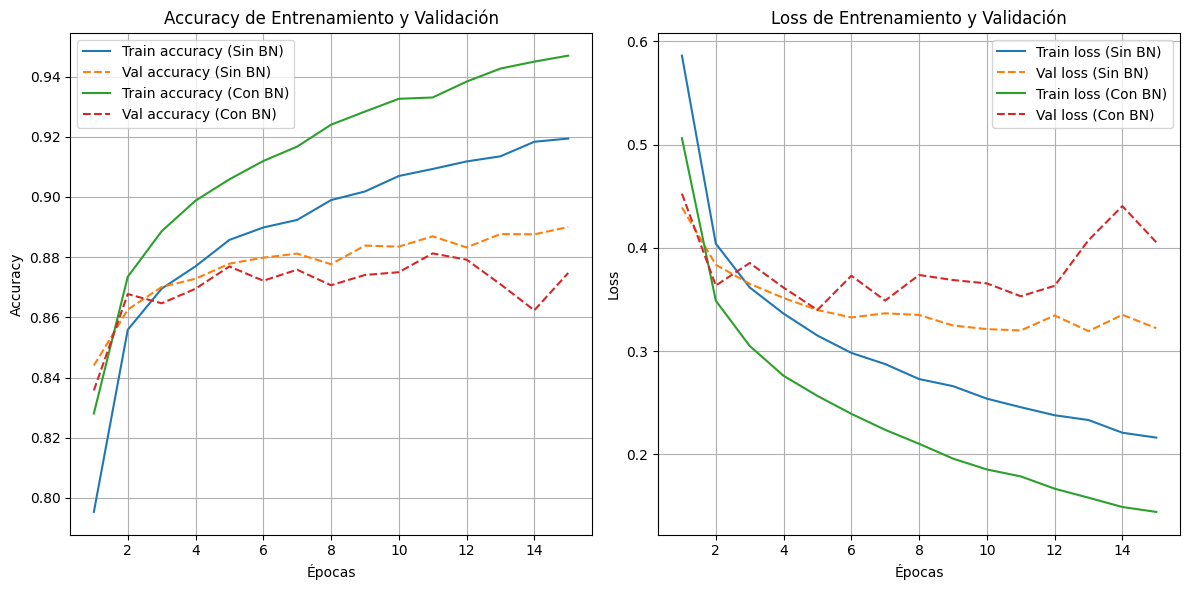


Evaluando en el conjunto de Test:
Modelo SIN BN - Test Loss: 0.3466, Test Accuracy: 0.8826
Modelo CON BN - Test Loss: 0.4379, Test Accuracy: 0.8644


In [9]:
# Ejemplo: Batch Normalization en Keras
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time # Para medir el tiempo de entrenamiento

# --- 1. Cargar y Preprocesar Datos ---
print("Cargando y preprocesando datos Fashion MNIST...")
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizar píxeles a [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode las etiquetas
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Forma datos entrenamiento: {x_train.shape}")
print(f"Forma etiquetas entrenamiento: {y_train_cat.shape}")
print(f"Forma datos prueba: {x_test.shape}")
print(f"Forma etiquetas prueba: {y_test_cat.shape}")

# --- 2. Definir los Modelos ---

def build_model_without_bn(input_shape):
    """Construye un modelo secuencial simple SIN Batch Normalization."""
    model = Sequential(name='Modelo_Sin_BN')
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2)) # Podríamos añadir Dropout si quisiéramos
    model.add(Dense(64))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax')) # Softmax para clasificación multiclase
    return model

def build_model_with_bn(input_shape):
    """Construye un modelo secuencial simple CON Batch Normalization."""
    model = Sequential(name='Modelo_Con_BN')
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128))
    # BN ANTES de la activación
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(64))
    # BN ANTES de la activación
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

input_shape = x_train.shape[1:] # (28, 28)

model_no_bn = build_model_without_bn(input_shape)
model_with_bn = build_model_with_bn(input_shape)

# Compilar los modelos
# Usaremos el mismo optimizador y función de pérdida
optimizer = Adam(learning_rate=0.001)
loss_fn = 'categorical_crossentropy'
metrics = ['accuracy']

model_no_bn.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
# Necesitamos clonar el optimizador para que cada modelo tenga su estado
optimizer_clone =Adam.from_config(optimizer.get_config())
# optimizer_clone = tf.keras.optimizers.Adam.from_config(optimizer.get_config()) # Para TF > 2.16 approx.

model_with_bn.compile(optimizer=optimizer_clone, loss=loss_fn, metrics=metrics)

print("\nResumen Modelo SIN Batch Normalization:")
model_no_bn.summary()

print("\nResumen Modelo CON Batch Normalization:")
model_with_bn.summary()
# Notar que BN añade parámetros entrenables (gamma y beta por cada característica)

# --- 3. Entrenar los Modelos ---
epochs = 15
batch_size = 128
validation_split = 0.2 # Usar parte del training set para validación

print("\nEntrenando Modelo SIN Batch Normalization...")
start_time = time.time()
history_no_bn = model_no_bn.fit(x_train, y_train_cat,
                                batch_size=batch_size,
                                epochs=epochs,
                                validation_split=validation_split,
                                verbose=2) # verbose=2 muestra una línea por época
end_time = time.time()
print(f"Tiempo entrenamiento SIN BN: {end_time - start_time:.2f} segundos")


print("\nEntrenando Modelo CON Batch Normalization...")
start_time = time.time()
history_with_bn = model_with_bn.fit(x_train, y_train_cat,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  validation_split=validation_split,
                                  verbose=2)
end_time = time.time()
print(f"Tiempo entrenamiento CON BN: {end_time - start_time:.2f} segundos")


# --- 4. Visualizar Resultados ---

def plot_history(histories, keys=('accuracy', 'loss')):
    """Función para graficar el historial de entrenamiento."""
    plt.figure(figsize=(12, 6))

    for i, key in enumerate(keys):
        plt.subplot(1, len(keys), i + 1)
        for name, history in histories.items():
            val_key = 'val_' + key
            epochs_range = range(1, len(history.history[key]) + 1)
            plt.plot(epochs_range, history.history[key], label=f'Train {key} ({name})')
            if val_key in history.history:
                plt.plot(epochs_range, history.history[val_key], label=f'Val {key} ({name})', linestyle='--')
        plt.xlabel('Épocas')
        plt.ylabel(key.capitalize())
        plt.title(f'{key.capitalize()} de Entrenamiento y Validación')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Crear diccionario de historiales para la función de ploteo
histories_dict = {
    'Sin BN': history_no_bn,
    'Con BN': history_with_bn
}

plot_history(histories_dict)

# --- 5. Evaluar en el Test Set ---
print("\nEvaluando en el conjunto de Test:")
loss_no_bn, acc_no_bn = model_no_bn.evaluate(x_test, y_test_cat, verbose=0)
loss_with_bn, acc_with_bn = model_with_bn.evaluate(x_test, y_test_cat, verbose=0)

print(f"Modelo SIN BN - Test Loss: {loss_no_bn:.4f}, Test Accuracy: {acc_no_bn:.4f}")
print(f"Modelo CON BN - Test Loss: {loss_with_bn:.4f}, Test Accuracy: {acc_with_bn:.4f}")


Al ejecutar el código anterior y observar las gráficas, se perciben algunas diferencias potenciales entre el modelo con y sin Batch Normalization:

1.  **Convergencia:** El modelo con BN *podría* converger más rápido, es decir, alcanzar un buen nivel de precisión en menos épocas. Sus curvas de pérdida (loss) podrían descender más rápidamente al inicio.
2.  **Estabilidad:** Las curvas de entrenamiento y validación del modelo con BN suelen ser más suaves y menos erráticas. BN ayuda a estabilizar el proceso de aprendizaje.
3.  **Rendimiento Final:** A menudo, BN permite alcanzar una mejor precisión final, tanto en el conjunto de validación como en el de prueba, ya que facilita el entrenamiento de redes más profundas y actúa como un leve regularizador.
4.  **Tiempo de Entrenamiento por Época:** Cada época del modelo *con* BN puede tardar ligeramente más, debido a los cálculos adicionales de normalización y los parámetros extra (gamma/beta). Sin embargo, si converge en menos épocas, el tiempo total podría ser menor.

Este ejemplo demuestra cómo integrar la capa `BatchNormalization` de Keras en un modelo secuencial y proporciona una base para observar experimentalmente sus beneficios en el entrenamiento de redes neuronales.

## 8. Early Stopping (Detención Temprana)

**¿Qué es?**
Early Stopping es otra técnica de **regularización** utilizada para prevenir el overfitting, especialmente en algoritmos iterativos como el descenso de gradiente (usado en redes neuronales, gradient boosting, etc.).

**Idea Principal:**
1.  Divide tus datos en conjuntos de **entrenamiento** y **validación**.
2.  Entrena el modelo de forma iterativa (por épocas o pasos).
3.  En cada iteración (o cada pocas iteraciones):
    * Evalúa el rendimiento del modelo (e.g., loss o accuracy) tanto en el conjunto de **entrenamiento** como en el de **validación**.
4.  Monitoriza la métrica de rendimiento en el **conjunto de validación**.
5.  **Detén el entrenamiento** tan pronto como la métrica de rendimiento en el conjunto de validación **deje de mejorar** o **empiece a empeorar**, incluso si la métrica en el conjunto de entrenamiento sigue mejorando.
6.  Opcionalmente, guarda el modelo correspondiente al punto donde el rendimiento de validación fue óptimo.

**¿Por qué funciona?**
El rendimiento en el conjunto de entrenamiento casi siempre mejora (o se estanca) a medida que el modelo se entrena más. Sin embargo, el rendimiento en el conjunto de validación típicamente mejora hasta cierto punto y luego empieza a empeorar a medida que el modelo comienza a sobreajustarse a los datos de entrenamiento. Early Stopping detiene el proceso justo antes (o poco después) de que comience el sobreajuste significativo.

**Parámetro 'Patience' (Paciencia):**
A menudo, la métrica de validación puede fluctuar un poco. Para evitar detener el entrenamiento prematuramente debido a una pequeña fluctuación aleatoria, se suele introducir un parámetro de "paciencia". Este parámetro define cuántas iteraciones esperar *después* de que la métrica de validación deje de mejorar, antes de detener realmente el entrenamiento. Si la métrica mejora de nuevo dentro del período de paciencia, el contador se reinicia.

**Ventajas:**
* Simple y efectivo para prevenir el overfitting.
* Puede reducir el tiempo total de entrenamiento.
* No requiere modificar la función de coste como L1/L2.

**Implementación:**
Se implementa monitorizando la métrica de validación dentro del bucle de entrenamiento. Muchas librerías (como Keras, XGBoost, LightGBM) tienen soporte incorporado para Early Stopping.

Epoch 1/100 - Train Loss: 0.9104 - Val Loss: 0.9820
  -> Mejor validación encontrada. Guardando modelo (simulado).
Epoch 2/100 - Train Loss: 0.5069 - Val Loss: 0.5689
  -> Mejor validación encontrada. Guardando modelo (simulado).
Epoch 3/100 - Train Loss: 0.3773 - Val Loss: 0.4566
  -> Mejor validación encontrada. Guardando modelo (simulado).
Epoch 4/100 - Train Loss: 0.3025 - Val Loss: 0.3772
  -> Mejor validación encontrada. Guardando modelo (simulado).
Epoch 5/100 - Train Loss: 0.2627 - Val Loss: 0.3283
  -> Mejor validación encontrada. Guardando modelo (simulado).
Epoch 6/100 - Train Loss: 0.2362 - Val Loss: 0.2899
  -> Mejor validación encontrada. Guardando modelo (simulado).
Epoch 7/100 - Train Loss: 0.2331 - Val Loss: 0.3089
  -> Validación no mejoró. Paciencia: 1/10
Epoch 8/100 - Train Loss: 0.2147 - Val Loss: 0.2887
  -> Mejor validación encontrada. Guardando modelo (simulado).
Epoch 9/100 - Train Loss: 0.1921 - Val Loss: 0.2477
  -> Mejor validación encontrada. Guardando mode

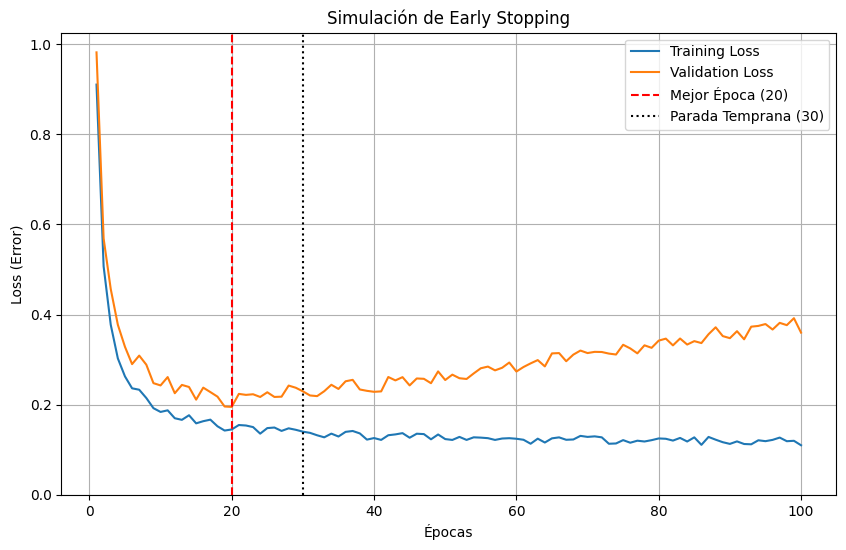

In [7]:
# Ejemplo Conceptual: Simulación de Early Stopping

import numpy as np
import matplotlib.pyplot as plt

# Simular métricas de error durante el entrenamiento (ej. MSE)
epochs = 100
# Error de entrenamiento: disminuye consistentemente (puede estabilizarse)
train_loss = 0.8 / (np.arange(epochs) + 1) + 0.1 + np.random.rand(epochs) * 0.02
# Error de validación: disminuye al principio, luego aumenta (overfitting)
val_loss = train_loss + 0.05 # Empieza similar
val_loss[20:] += np.linspace(0, 0.2, epochs - 20) # Aumenta gradualmente después de la época 20
val_loss += np.random.rand(epochs) * 0.03 # Añadir algo de ruido

# --- Lógica de Early Stopping ---
patience = 10 # Número de épocas a esperar antes de detener
best_val_loss = np.inf
best_epoch = 0
epochs_no_improve = 0
stopped_epoch = epochs # Por defecto, si no se detiene antes

for epoch in range(epochs):
    current_val_loss = val_loss[epoch]
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss[epoch]:.4f} - Val Loss: {current_val_loss:.4f}")

    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_epoch = epoch
        epochs_no_improve = 0
        print(f"  -> Mejor validación encontrada. Guardando modelo (simulado).")
    else:
        epochs_no_improve += 1
        print(f"  -> Validación no mejoró. Paciencia: {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print(f"\n¡EARLY STOPPING! Deteniendo en la época {epoch+1}.")
        stopped_epoch = epoch + 1
        break # Salir del bucle de entrenamiento

print(f"\nEntrenamiento finalizado.")
print(f"Mejor época (según validación): {best_epoch + 1}")
print(f"Mejor Loss de Validación: {best_val_loss:.4f}")
if stopped_epoch < epochs:
     print(f"El entrenamiento se detuvo temprano en la época: {stopped_epoch}")
else:
     print(f"El entrenamiento completó todas las {epochs} épocas.")

# Graficar las curvas de loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
plt.axvline(best_epoch + 1, color='r', linestyle='--', label=f'Mejor Época ({best_epoch + 1})')
if stopped_epoch < epochs:
    plt.axvline(stopped_epoch, color='k', linestyle=':', label=f'Parada Temprana ({stopped_epoch})')
plt.title('Simulación de Early Stopping')
plt.xlabel('Épocas')
plt.ylabel('Loss (Error)')
plt.legend()
plt.ylim(0, plt.ylim()[1]) # Asegurar que el eje Y empieza en 0 o cerca
plt.grid(True)
plt.show()